In [6]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from transformer import *
from hybrid_loss import *
from model import *
from evaluation import *

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

## Final Performance Analysis Notebook for 1D Flash Detection

**Model Versions:**
* Enumerate model versions to test

**Single Flash Statistics (Performance Upper Bounds)**
* Accuracy vs. # Photons
* Purity vs. # Photons
* Predicted Interval Width vs. # Photons
* Reconstructed # Photons vs. # Photons

**Double Flash Statistics**
* Accuracy PER FLASH vs. Photon Ratio
* Reconstructed # Photons PER FLASH vs. Photon Ratio
* Purity vs. Photon Ratio
* Accuracy PER FLASH vs. Delta T
* Reconstructed # Photons PER FLASH vs. Delta T
* Purity vs. Delta T

In [2]:
model_paths = [
"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_28_130.pth",
"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/200k_unet_28_49.pth",

]

device = 'cuda'

transformer_130 = TransformerModel()
transformer_130.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_28_130.pth", weights_only=False)
transformer_130.load_state_dict(checkpoint['model_state_dict'])
transformer_130.eval()

unet_50 = UNet1D()
unet_50.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/200k_unet_28_49.pth", weights_only=False)
unet_50.load_state_dict(checkpoint['model_state_dict'])
unet_50.eval()

model_list = [transformer_130]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### Single Flash Statistics

In [3]:
# Data sample for single-flashes
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/1delayphot_reg.npy', allow_pickle=True)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list

merge_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

/lscratch/carsmith/tmp/ipykernel_2712996/3622485179.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


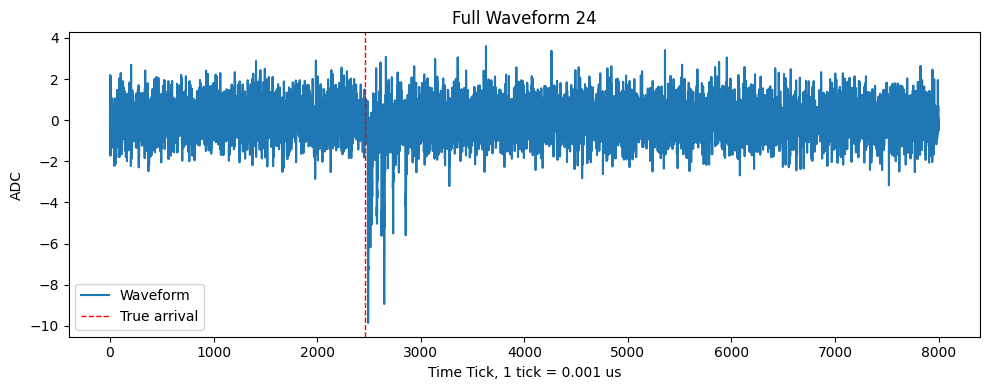

In [4]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(merge_loader))
ticks = np.arange(waveforms[0].shape[1])
waveform_id = 24
wf = waveforms[waveform_id]
ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]
plt.figure(figsize = (10, 4))
plt.plot(ticks, wf, alpha=1, label='Waveform')

for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
        
plt.title(f"Full Waveform {waveform_id}")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
bin_width = 100
batches_per_photon = 4

# Put all models you want to evaluate in a dict
# keys = names, values = model objects
models = {
    "tr": transformer_130,
    "unet": unet_50
    # "myother": my_other_model,
}

single_phot_results = {name: {"interval": [], "reco_frac": []} for name in models.keys()}
epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(merge_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

    # temporary accumulators
    interval_bins = {name: [] for name in models.keys()}
    reco_frac = {name: 0.0 for name in models.keys()}

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            # loop through all models in dict
            for name, model in models.items():
                # forward pass (assume callable model returns (class_output, reg_output))
                # adapt if some models need extra args like mode='bce'
                if name == "tr":
                    class_output, reg_output = model(data, mode="bce")
                else:
                    class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5)

                # interval widths
                for b in range(merged_mask.shape[0]):
                    mask_row = merged_mask[b, 0]
                    intervals = mask_to_intervals(mask_row)
                    widths = [(e - s + 1) for (s, e) in intervals]
                    interval_bins[name].extend(widths)

                # summed photons per interval
                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                pred = torch.tensor([np.sum(x) for x in interval_pred_sums])
                true = torch.tensor([np.sum(x) for x in interval_true_sums])
                mask = true > 0
                if mask.any():
                    reco_frac[name] += torch.mean(pred[mask] / true[mask]).item()

            # record stats once per photon bin
            if (i + 1) % batches_per_photon == 0:
                for name in models.keys():
                    reco_frac[name] /= batches_per_photon
                    avg_interval = np.mean(interval_bins[name]) if interval_bins[name] else 0.0

                    single_phot_results[name]["interval"].append(avg_interval)
                    single_phot_results[name]["reco_frac"].append(reco_frac[name])

                    # reset accumulators
                    interval_bins[name] = []
                    reco_frac[name] = 0.0

np.save("test.npy", single_phot_results, allow_pickle=True)

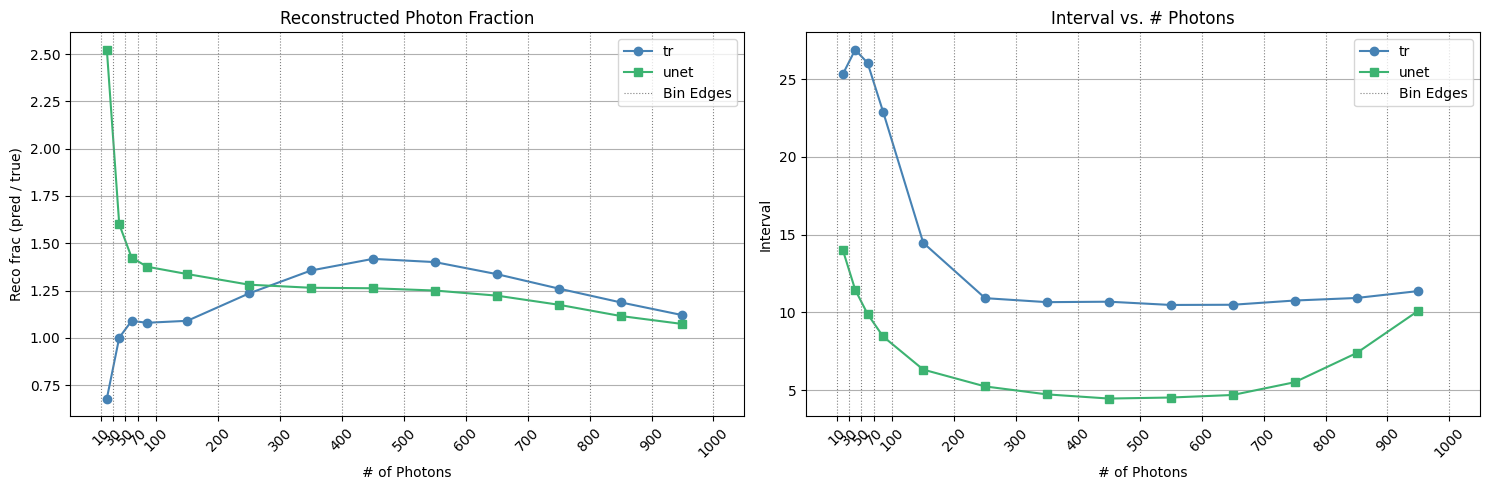

In [8]:
results = np.load("test.npy", allow_pickle=True).item()

model_names = list(results.keys())   # ['tr', 'unet']
colors = ["steelblue", "mediumseagreen", "orange", "pink", "purple"]
markers = ["o", "s", "D", "v", "^"]

# Convert each model's data into arrays
model_reco_frac = {name: np.array(results[name]["reco_frac"]) for name in model_names}
model_interval = {name: np.array(results[name]["interval"]) for name in model_names}

# Define binning
bin_size = 100
ref_data = next(iter(model_reco_frac.values()))  # reference length
bin_sizes = [20, 20, 20, 30] + [bin_size] * (len(ref_data) // bin_size)
bin_edges = np.cumsum([10] + bin_sizes)
bin_centers = bin_edges[:-1] + (np.array(bin_sizes) / 2)

def bin_data(arr, bin_sizes):
    """Average data into bins of variable width."""
    out, start = [], 0
    for b in bin_sizes:
        out.append(arr[start:start+b].mean())
        start += b
    return np.array(out)

# Create 1x2 plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# -------- Plot reco_frac --------
ax = axes[0]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_reco_frac[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

# Bin edges
for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

ax.set_xlabel("# of Photons")
ax.set_ylabel("Reco frac (pred / true)")
ax.set_title("Reconstructed Photon Fraction")
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.grid(axis="y")
ax.legend()

# -------- Plot interval --------
ax = axes[1]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_interval[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

ax.set_xlabel("# of Photons")
ax.set_ylabel("Interval")
ax.set_title("Interval vs. # Photons")
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.grid(axis="y")
ax.legend()

plt.tight_layout()
plt.show()

### Double Flash (Delta T) Statistics

In [3]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delta_t_random.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

delta_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

In [7]:
bin_width = 100
batches_per_photon = 400

# Put models into a dict
models = {
    "tr": transformer_130,
    "unet": unet_50
    # "myother": my_other_model,
}

# Initialize results dict: each model gets its own metrics
results = {
    name: {"reco_frac_flash1": [], "reco_frac_flash2": [], "merge_acc_flash1": [], "merge_acc_flash2": [], "merge_pure": []}
    for name in models.keys()
}

epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(
        delta_loader,
        desc=f"Scanning {epoch+1}/{epochs}",
        leave=False,
        position=0
    )

    # Temporary accumulators for per-photon-bin averages
    reco_frac_flash1 = {name: 0.0 for name in models.keys()}
    reco_frac_flash2 = {name: 0.0 for name in models.keys()}
    merge_acc_flash1 = {name: 0.0 for name in models.keys()}
    merge_acc_flash2 = {name: 0.0 for name in models.keys()}
    merge_pure = {name: 0.0 for name in models.keys()}

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            # loop through all models
            for name, model in models.items():
                if name == "tr":
                    class_output, reg_output = model(data, mode="bce")
                else:
                    class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5)

                # Summed Photons per Interval
                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                pred = torch.tensor([np.sum(x) for x in interval_pred_sums])
                true = torch.tensor([np.sum(x) for x in interval_true_sums])
                mask = true > 0
                # if mask.any():
                if mask.sum() >= 2:  # make sure at least two flashes survived got detected
                    valid_idx = torch.where(mask)[0]
                    reco_frac_flash1[name] += (pred[valid_idx[0]] / true[valid_idx[0]]).item()
                    reco_frac_flash2[name] += (pred[valid_idx[1]] / true[valid_idx[1]]).item()
                    # reco_frac[name] += torch.mean(pred[mask] / true[mask]).item() # average

                # Merging metrics
                flash1_acc, flash2_acc = merged_twoflash_acc(merged_mask, hit_times, device)
                merge_acc_flash1[name] += flash1_acc
                merge_acc_flash2[name] += flash2_acc

                merge_pure[name] += merged_class_purity(merged_mask, hit_times, device)

            # Record stats once per photon bin
            if (i + 1) % batches_per_photon == 0:
                for name in models.keys():
                    reco_frac_flash1[name] /= batches_per_photon
                    reco_frac_flash2[name] /= batches_per_photon
                    merge_acc_flash1[name] /= batches_per_photon
                    merge_acc_flash2[name] /= batches_per_photon
                    merge_pure[name] /= batches_per_photon

                    results[name]["reco_frac_flash1"].append(reco_frac_flash1[name])
                    results[name]["reco_frac_flash2"].append(reco_frac_flash2[name])
                    results[name]["merge_acc_flash1"].append(merge_acc_flash1[name])
                    results[name]["merge_acc_flash2"].append(merge_acc_flash2[name])
                    results[name]["merge_pure"].append(merge_pure[name])

                    # reset accumulators
                    reco_frac_flash1[name] = 0.0
                    reco_frac_flash2[name] = 0.0
                    merge_acc_flash1[name] = 0.0
                    merge_acc_flash2[name] = 0.0
                    merge_pure[name] = 0.0

np.save("test_ratiostats.npy", results, allow_pickle=True)

KeyboardInterrupt: 

In [ ]:
# Load new results (e.g., from 130 epochs run)
results = np.load("test_ratiostats.npy", allow_pickle=True).item()
ratios = ["(0.1,0.2)", "(0.2,0.5)", "(0.5,1.0)", "(1.0,2.0)",
          "(2.0,5.0)", "(5.0,7.0)", "(7.0,10.0)"]
ticks = np.arange(len(ratios))

metrics = {
    "Flash Accuracies": ["merge_acc_flash1", "merge_acc_flash2"],
    "Purity": ["merge_pure"],
    "Reco Fraction": ["reco_frac_flash1", "reco_frac_flash2"],
}

colors = ["steelblue", "darkblue", "darkgreen", "mediumseagreen", "brown"]
markers = ["o", "s", "D", "v", "^"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

for ax, (title, metric_keys) in zip(axes, metrics.items()):
    for idx, model_name in enumerate(results.keys()):
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]

        for m in metric_keys:  # could be one or two
            arr = np.array(results[model_name][m])
            label_suffix = "Flash 1" if m.endswith("flash1") else "Flash 2" if m.endswith("flash2") else ""
            ax.plot(
                ticks, arr,
                marker=marker,
                label=f"{model_name} {label_suffix}" if label_suffix else f"{model_name}"
            )

    ax.set_title(title)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ratios, rotation=45)

axes[0].set_ylabel("Score")
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
# Delta T buckets
'''
In dataloader, samples are sorted by photon ratio
But, we can re-arrange with delta t: hit_times[1] - hit_times[0]
For now, collect stats by 1 ns binning, but we can aggregate later
'''
bin_width = 100
batches_per_photon = 400
models = {
    "tr": transformer_130,
    "unet": unet_50
}

delta_results = {
    name: {
        "bin_counts": torch.zeros(1501),
        "reco_frac_flash1": torch.zeros(1501),
        "reco_frac_flash2": torch.zeros(1501),
        "merge_acc_flash1": torch.zeros(1501),
        "merge_acc_flash2": torch.zeros(1501),
        "merge_pure": torch.zeros(1501)
    }
    for name in models.keys()
}

epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(delta_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            indices = torch.tensor([int(t[1] - t[0]) for t in hit_times], dtype=torch.long)

            for name, model in models.items():
                if name == "tr":
                    class_output, reg_output = model(data, mode="bce")
                else:
                    class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5)

                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)# [[], [], []]
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                flash1_acc_ls, flash2_acc_ls = merged_twoflash_acc(merged_mask, hit_times, device, no_sum=True)
                purity_ls = merged_class_purity(merged_mask, hit_times, device, no_sum=True)

                for b, idx in enumerate(indices):
                    delta_results[name]["bin_counts"][idx] += 1

                    mask = np.array(interval_true_sums[b]) > 0
                    valid_idx = np.where(mask)

                    if len(valid_idx[0]) >= 2:
                        delta_results[name]["reco_frac_flash1"][idx] += (interval_pred_sums[b][valid_idx[0][0]] / interval_true_sums[b][valid_idx[0][0]]).item()
                        delta_results[name]["reco_frac_flash2"][idx] += (interval_pred_sums[b][valid_idx[0][1]] / interval_true_sums[b][valid_idx[0][1]]).item()

                    delta_results[name]["merge_acc_flash1"][idx] += flash1_acc_ls[b]
                    delta_results[name]["merge_acc_flash2"][idx] += flash2_acc_ls[b]
                    delta_results[name]["merge_pure"][idx] += purity_ls[b]

# Normalize by per-model bin counts
for name in models.keys():
    counts = delta_results[name]["bin_counts"].clone()
    counts[counts == 0] = 1  # prevent division by zero
    for key in delta_results[name]:
        if key != "bin_counts":
            delta_results[name][key] /= counts

np.save("deltastats_100k.npy", delta_results, allow_pickle=True)

Scanning 1/1:  25%|██▍       | 982/4000 [04:12<13:04,  3.85it/s]

In [ ]:
def aggregate_bins(delta_results, bin_size=1):
    """
    Aggregate results into coarser bins.
    bin_size = number of indices to merge (e.g. 10 for 10 ns bins).
    Uses mean over bins.
    """
    agg_results = {}

    for model, metrics in delta_results.items():
        agg_results[model] = {}
        n_bins = len(next(iter(metrics.values())))

        # Number of new bins after aggregation
        n_new = n_bins // bin_size
        new_bins = np.arange(n_new) * bin_size

        for key, arr in metrics.items():
            arr = np.array(arr)
            # truncate so it's divisible by bin_size
            arr = arr[:n_new * bin_size]
            arr = arr.reshape(n_new, bin_size).mean(axis=1)
            agg_results[model][key] = arr

        # Store new bin centers
        agg_results[model]["bin_centers"] = new_bins + bin_size / 2

    return agg_results

In [ ]:
delta_results = np.load("deltastats_100k.npy", allow_pickle=True).item()
print(delta_results['unet']["reco_frac_flash1"])

In [ ]:
# Load saved results
delta_results = np.load("deltastats_100k.npy", allow_pickle=True).item()

# Aggregate bins (change bin_size=10 for 10 ns bins, etc.)
bin_size = 30
delta_results = aggregate_bins(delta_results, bin_size=bin_size)

models = list(delta_results.keys())

paired_metrics = {
    "reco_frac": ("reco_frac_flash1", "reco_frac_flash2"),
    "merge_acc": ("merge_acc_flash1", "merge_acc_flash2"),
}
single_metrics = ["merge_pure"]

ncols = len(paired_metrics) + len(single_metrics)
nrows = len(models)

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True)

if nrows == 1:
    axes = np.expand_dims(axes, 0)

colors = ["steelblue", "darkorange"]

for row, model in enumerate(models):
    results = delta_results[model]
    bin_centers = results["bin_centers"] + 50

    # ---- Paired metrics ----
    for col, (metric_name, (flash1_key, flash2_key)) in enumerate(paired_metrics.items()):
        ax = axes[row, col]
        ax.plot(bin_centers, results[flash1_key], label=f"Flash 1", color=colors[0], marker="o")
        ax.plot(bin_centers, results[flash2_key], label=f"Flash 2", color=colors[1], marker="s")

        ax.set_title(f"{model} - {metric_name}")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.4)

        if row == nrows - 1:
            ax.set_xlabel(f"Separation (ns, aggregated by {bin_size})")
        if row == 0:
            ax.legend()

    # ---- Single metrics ----
    for j, metric_name in enumerate(single_metrics):
        col = len(paired_metrics) + j
        ax = axes[row, col]
        ax.plot(bin_centers, results[metric_name], label=metric_name, color="mediumseagreen", marker="D")

        ax.set_title(f"{model} - {metric_name}")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.4)

        if row == nrows - 1:
            ax.set_xlabel(f"Separation (ns, aggregated by {bin_size})")
        if row == 0:
            ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(torch.mean(counts))